#***Import libraries***

In [ ]:
!pip install tensorflow_addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 7.3 MB/s eta 0:00:00


In [ ]:
# Basic
import os
import numpy as np
import random
import shutil

# Visualization
import plotly.express as px
import matplotlib.pyplot as plt
import cv2
from google.colab.patches import cv2_imshow

# Build and train model
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras import layers as L
from tensorflow.keras.applications import MobileNetV2
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


#1 - Tải và giải nén tập dữ liệu

In [ ]:
%%shell
pip -q install --upgrade --no-cache-dir gdown
gdown -q 1osyF8tE8GQb_0wxcSFMJrMNEUXMnk-bu
echo 'download: done => file: split_dataset.zip'
rm -rf ./split_dataset/
unzip -q split_dataset.zip

download: done => file: split_dataset.zip


#2 - Đọc dữ liệu vào

## 2.1 - Lấy tên các lớp trong tập dữ liệu





In [ ]:
train_path = "/content/split_dataset/images/train"
val_path = "/content/split_dataset/images/valid"

class_names = list(filter(lambda f: os.path.isdir(os.path.join(train_path, f)), os.listdir(train_path)))
class_names = sorted(class_names)
print(f"Tên các lớp trong dataset: \n{class_names}")

Tên các lớp trong dataset: 
['cam', 'chi_dan', 'hieu_lenh', 'nguy_hiem', 'phu']


## 2.2 - Lấy dữ liệu từ các file csv

In [ ]:
csv_dic = {}

csvFileNames = os.listdir("/content/split_dataset/bbox")
for csvFileName in csvFileNames:
  csvPath = os.path.join("/content/split_dataset/bbox", csvFileName)
  rows = open(csvPath).read().strip().split("\n")
  rows = rows[1:]
  for row in rows:
    (filename, x1, y1, x2, y2, label) = row.split(",")
    csv_dic[filename] = (float(x1), float(y1), float(x2), float(y2))

len(csv_dic)

5857

## 2.3 - Tạo hàm để tách dữ liệu và trực quan dữ liệu đầu vào

In [ ]:
input_size = (224, 224)

In [ ]:
def get_data(data):
  global cvs_dic, input_size
  image = []
  bbox = []
  label = []

  for path in data.file_paths:
    img = cv2.resize(cv2.imread(path), input_size)
    image.append(img)
    p = path.split("/")
    name, lab = p[-1], p[-2]
    bbox.append(csv_dic[name])
    label.append(lab)

  return np.asarray(image), np.asarray(bbox), np.asarray(label)

In [ ]:
def show_images(images, bboxes, labels):
  plt.figure(figsize=(16,16))
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    ax.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
    ax.set_title(labels[i])
    ax.axis("off")
  plt.suptitle("Samples from dataset")
  plt.show()

### 2.3.1 - Train

Found 4685 files belonging to 1 classes.
Done!


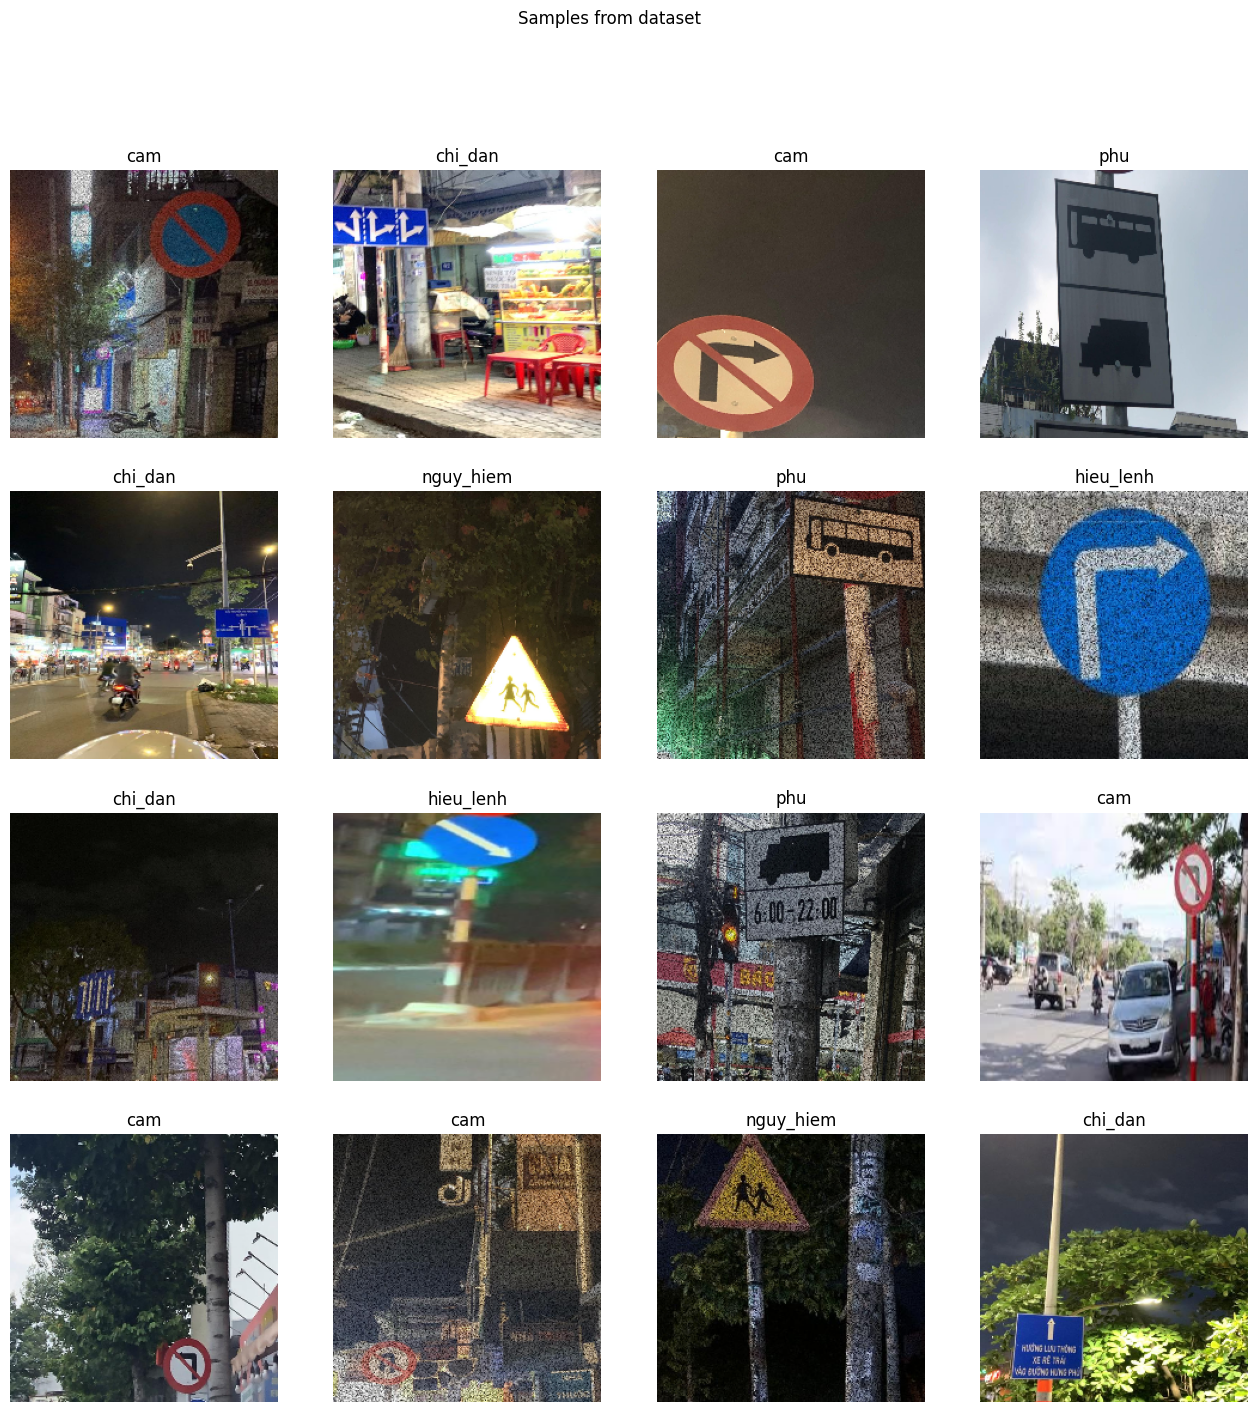

In [ ]:
train_set = image_dataset_from_directory(
  train_path,
  image_size=(224, 224),
  batch_size=16,
  label_mode=None,
  shuffle=True)

t = "train"
image_train, bbox_train, label_train = get_data(train_set)
print("Done!")
show_images(image_train, bbox_train, label_train)

### 2.3.2 - Valid

Found 585 files belonging to 1 classes.
Done!


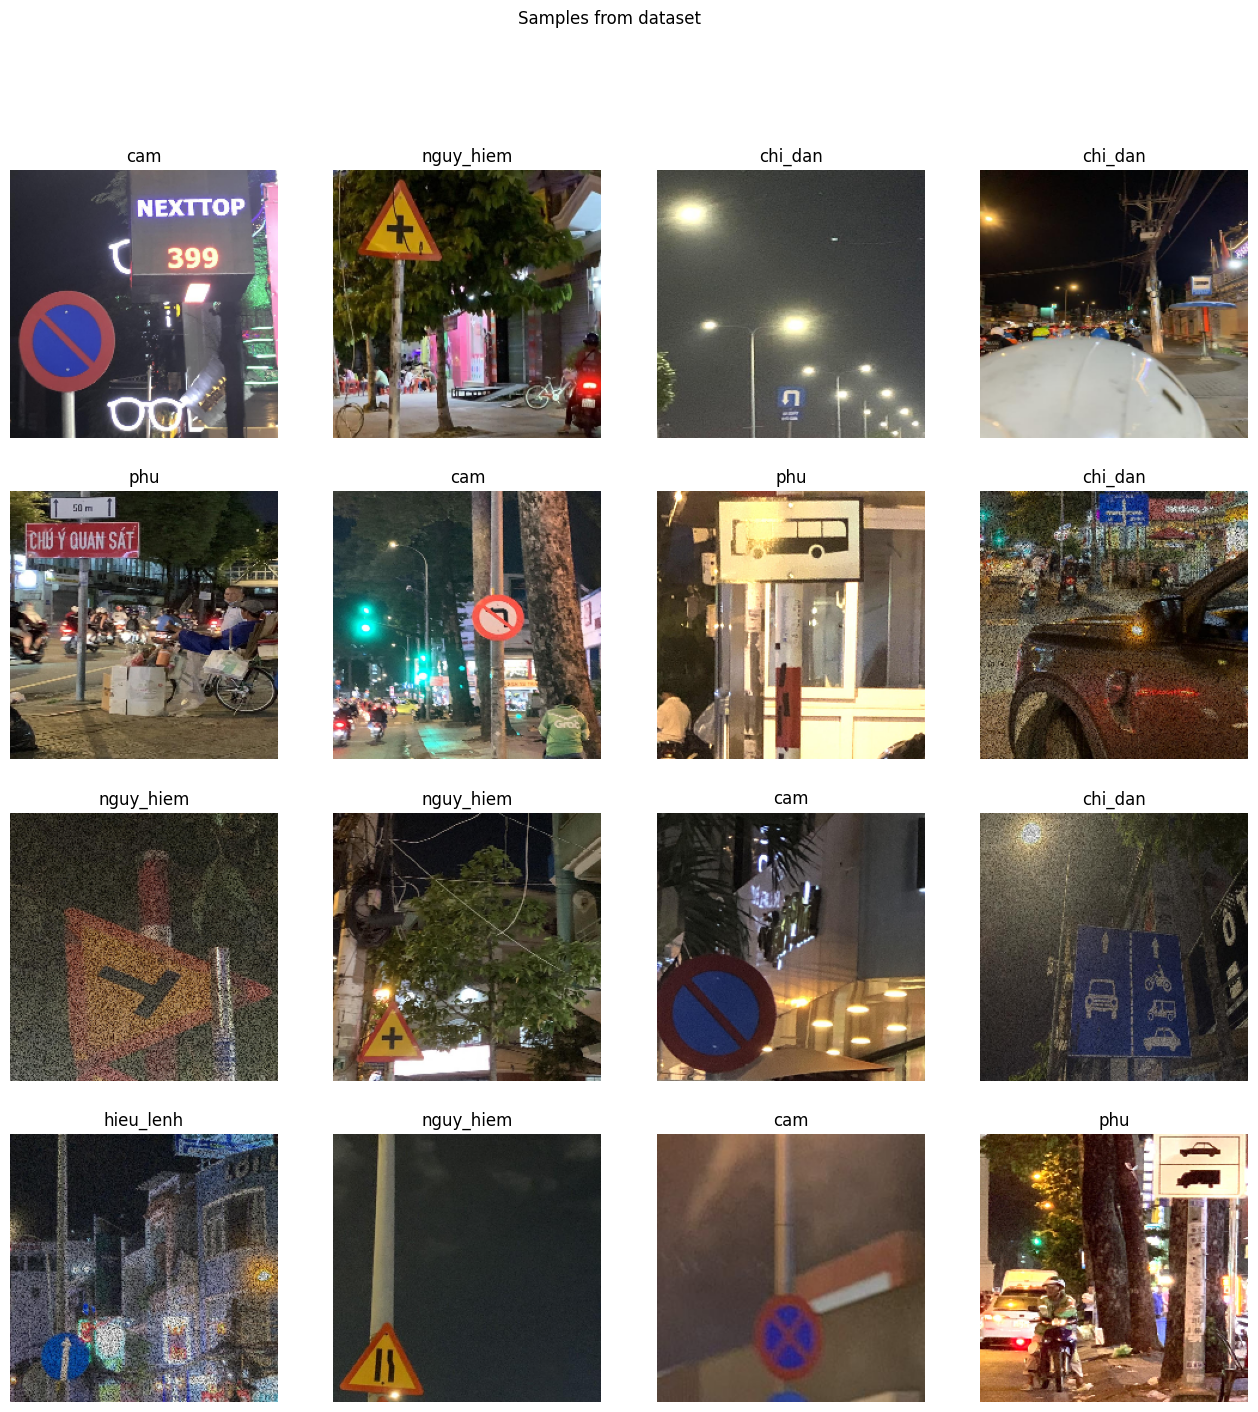

In [ ]:
valid_set = image_dataset_from_directory(
  val_path,
  image_size=(224, 224),
  batch_size=16,
  label_mode=None,
  shuffle=True)

image_valid, bbox_valid, label_valid = get_data(valid_set)
print("Done!")
show_images(image_valid, bbox_valid, label_valid)

In [ ]:
lb = LabelBinarizer()
label_train = lb.fit_transform(label_train)
label_valid = lb.fit_transform(label_valid)

#3 - Trực quan hóa phân bố dữ liệu

In [ ]:
class_dis = [(len(os.listdir(train_path + f"/{name}")) + len(os.listdir(val_path + f"/{name}"))) for name in class_names]
lk_dis = dict(zip(class_names, class_dis))
print(f"Phân bố dữ liệu : \n{lk_dis}")

fig = px.pie(names=class_names, values=class_dis, width=600)
fig.update_layout({"title":{'text':"Phân bố dữ liệu","x":0.5}})
fig.show()

Phân bố dữ liệu : 
{'cam': 1137, 'chi_dan': 1277, 'hieu_lenh': 1017, 'nguy_hiem': 900, 'phu': 939}


#4 - Huấn luyện mô hình

## 4.1 - Hàm tạo mô hình

In [ ]:
def build_model(input_shape, num_classes):
  #Inputs
  inputs = L.Input(input_shape)

  #Backbone
  backbone = MobileNetV2(
      include_top = False,
      weights = "imagenet",
      input_tensor = inputs,
      alpha = 1.0
  )

  x = backbone.output
  x = L.Conv2D(256, kernel_size = 1, padding = "same")(x)
  x = L.BatchNormalization()(x)
  x = L.Activation("relu")(x)
  x = L.GlobalAveragePooling2D()(x)
  x = L.Dropout(0.5)(x)

  bbox = L.Dense(4, activation = "sigmoid", name = "bbox")(x)
  label = L.Dense(num_classes, activation = "softmax", name = "label")(x)

  model = Model(inputs = inputs, outputs = [bbox, label])
  return model

Link tham khảo: https://www.youtube.com/watch?v=2b7nwPeIj40&list=WL&index=2

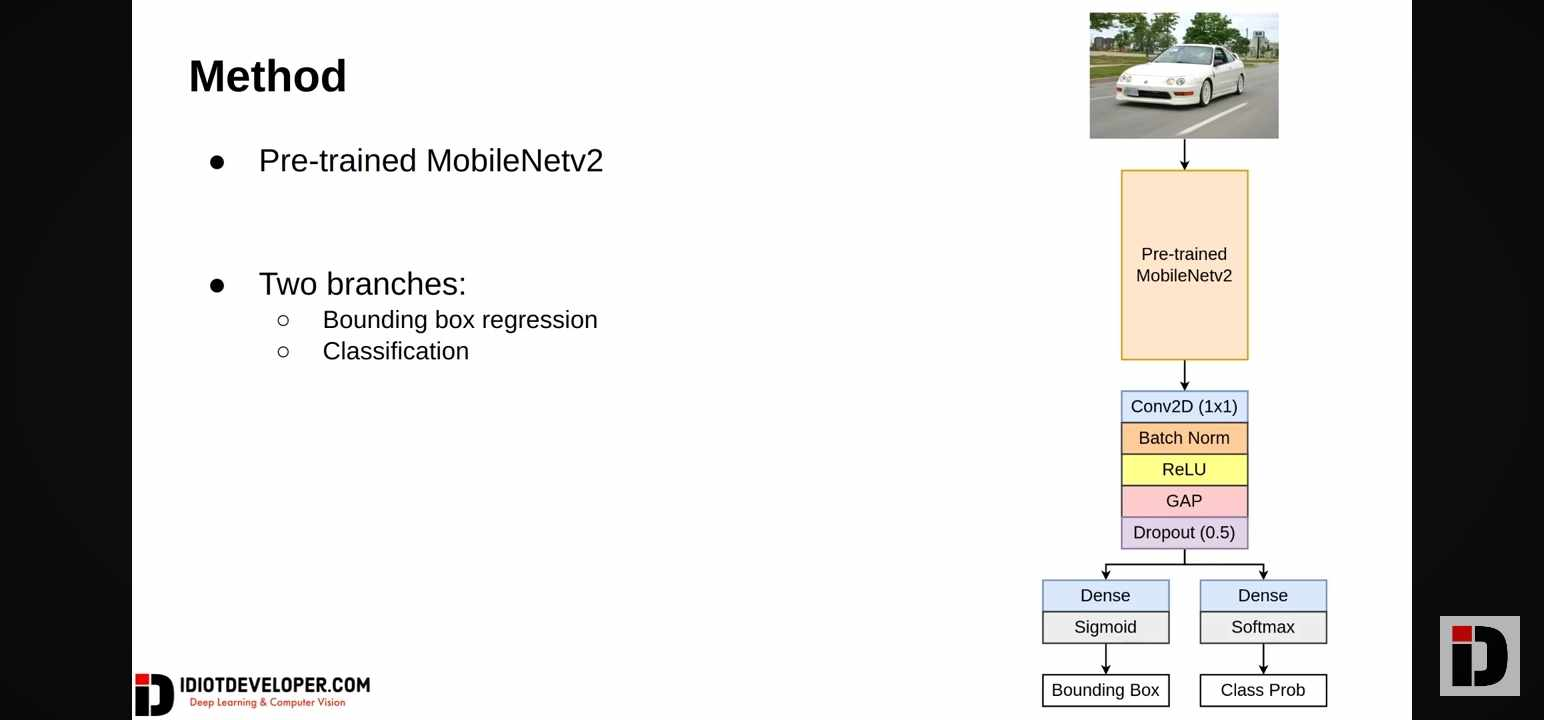

## 4.2 Khởi tạo mô hình, các thông số của mô hình

In [ ]:
model = build_model((input_size[0], input_size[1], 3), 5)
model.summary()

9406464/9406464 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (N

## 4.3 - Huấn luyện mô hình

In [ ]:
lr = 1e-4

# Định nghĩa losses cho các hàm losses
losses = {
    "bbox": "binary_crossentropy",
    "label": "categorical_crossentropy",
}

model.compile(
  loss=losses,
  optimizer=Adam(lr),
)

callbacks = [
    ModelCheckpoint("MobileNet.h5", verbose = 1, save_best_only = True),
    ReduceLROnPlateau(monitor = "val_loss", factor = 0.1, patience = 1, min_lr = 1e-7, verbose = 1),
    EarlyStopping(monitor = "val_loss", patience = 5, restore_best_weights = False)
]

H = model.fit(
    x=image_train,
    y=[bbox_train, label_train],
    validation_data=(image_valid, [bbox_valid, label_valid]),
    batch_size=128,
    epochs=100,
    callbacks = callbacks,
    verbose=1
)

Epoch 1/100
37/37 [==============================] - ETA: 0s - loss: 1.5792 - bbox_loss: 0.6950 - label_loss: 0.8842
Epoch 1: val_loss improved from inf to 1.75244, saving model to MobileNet.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



37/37 [==============================] - 63s 687ms/step - loss: 1.5792 - bbox_loss: 0.6950 - label_loss: 0.8842 - val_loss: 1.7524 - val_bbox_loss: 0.6527 - val_label_loss: 1.0998 - lr: 1.0000e-04
Epoch 2/100
37/37 [==============================] - ETA: 0s - loss: 0.7809 - bbox_loss: 0.6359 - label_loss: 0.1450
Epoch 2: val_loss improved from 1.75244 to 1.47153, saving model to MobileNet.h5
37/37 [==============================] - 20s 536ms/step - loss: 0.7809 - bbox_loss: 0.6359 - label_loss: 0.1450 - val_loss: 1.4715 - val_bbox_loss: 0.6291 - val_label_loss: 0.8424 - lr: 1.0000e-04
Epoch 3/100
37/37 [==============================] - ETA: 0s - loss: 0.6589 - bbox_loss: 0.6027 - label_loss: 0.0562
Epoch 3: val_loss improved from 1.47153 to 1.06017, saving model to MobileNet.h5
37/37 [==============================] - 20s 539ms/step - loss: 0.6589 - bbox_loss: 0.6027 - label_loss: 0.0562 - val_loss: 1.0602 - val_bbox_loss: 0.5922 - val_label_loss: 0.4680 - lr: 1.0000e-04
Epoch 4/100
3

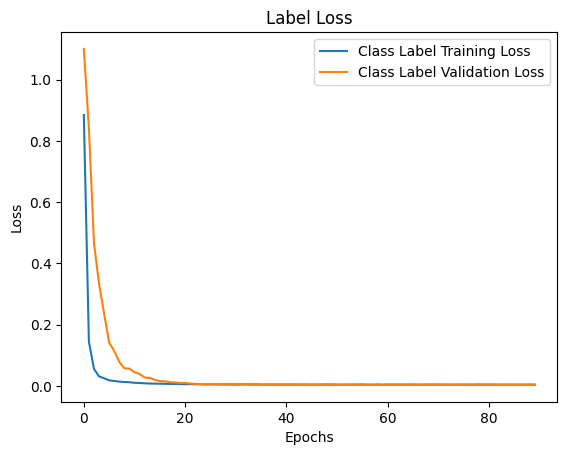

In [ ]:
# Plot label loss
plt.plot(H.history['label_loss'], label='Class Label Training Loss')
plt.plot(H.history['val_label_loss'], label='Class Label Validation Loss')
plt.title('Label Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Plot bbox loss
plt.plot(H.history['bbox_loss'], label='Bounding Box Training Loss')
plt.plot(H.history['val_bbox_loss'], label='Bounding Box Validation Loss')
plt.title('Bounding Box Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
file_path = 'MobileNet.h5'
drive_folder_path = '/content/drive/MyDrive/Colab Notebooks/Deep_Learning/THE_PROJECT/MobileNet.h5'
shutil.copy2(file_path, drive_folder_path)

'/content/drive/MyDrive/Colab Notebooks/Deep_Learning/THE_PROJECT/MobileNet.h5'